# Title

<center><font size="6"><b>Taylor Swift: The Eras Tour</b></font></center>
<center><font size="2">Predicting if a Taylor Swift song would be popular</font></center>

<img src="./TaylorSwift.jpg" width="300" height="150">
<center> Figure 01. The Eras Tour Concert Promotional Photo.[1] </center>

# Executive Summary

Taylor Swift is an American singer-songwriter born on December 13, 1989. She debuted in 2006 with her self-titled album. And last October 2022, she released her 10th studio album, Midnights. With that recent album, she made history by being the first artist to occupy the entire top 10 of Billboard Hot 100 in the same week. It begs the question of what makes her song popular. Knowing whether a song would be popular before it is even released, she can improve it based only on the audio characteristics and mood.


Different categorical feature handling will be used, and new types of categorical encoding will be introduced: ***Binary Encoding*** and ***Base N Encoding***. This new encoding type solves the issue of One-Hot Encoding when a categorical feature has high cardinality. But using this type of encoding technique has its disadvantage. In addition, a new experimental parameter, `enable_categorical` of the XGBoost model, will also be demonstrated. This new parameter is recommended to handle categorical features in XGBoost as this will not lose the feature importance information.


A total of 11 machine-learning methods will be used to model the data. Three models stood out: `GBM`, `XGBoost`, and `AdaBoost`, all of which achieved a ***test accuracy greater than 70%*** beating the 64% 1.25PCC. For almost all models, ***Speechiness*** (amount of spoken words in a song) is the top predictor of popularity which is not surprising since Taylor Swift is well known for her storytelling in her songs. In addition, for further study, it is recommended to include the analysis of words in Taylor Swift's songs using other techniques, such as Natural Language Processing. We can discover more information to predict her song's popularity.

# Highlights

1. We demonstrated when and how to use other types of categorical encoders: Binary Encoder and Base N Encoder.
2. We demonstrated how to use the new parameter of the XGBoost model called enable_categorical.
3. We performed GridSearchCV on 11 ML methods to find the best model and show the data top predictor.

# Methodology

***Data Preprocessing***
* Only necessary libraries will be imported, and it will be divided into three: basic imports, processing, models
* The dataset was downloaded from kaggle [[2]](https://www.kaggle.com/datasets/thespacefreak/taylor-swift-spotify-data) and supplemented by other dataset in DEV [[3]](https://dev.to/mage_ai/using-machine-learning-ml-to-generate-the-ultimate-taylor-swift-playlist-50e8).
* Missing data will be checked and fixed if necessary.
* Categorical data will be clean; specifically, the `popularity` will be converted into categorical variables of `0` (not popular) and `1` (popular). In addition, the number of unique categories in the `Mood` feature will be reduced to 7 by grouping all low-frequency categories into `Others`.
* Proportion Chance Criterion (PCC) will be calculated and serve as our models' baseline.
* Popularity will be set as the target variable (`y`) and the rest of the features as the predictor variables (`X`). 
* Two sets of `X` will be prepared, one that is not scaled while the other is scaled. The scaled will be used for non-tree-based models, while the non-scaled will be utilized for tree-based models.

***Exploratory Data Analysis***
* Target variable count will be plotted to showcase that the dataset is not imbalanced.
* Pairplot, heatmap, and correlation plots will be used to explore the data.

***Data Modeling***
* Different categorical encodings will be used to demonstrate how to implement them. In addition, their benefits and disadvantages will be discussed. Listed below are the different kinds of categorical data handling shown in the notebook:
    * Label Encoding
    * One Hot Encoding / Dummy Encoding
    * Binary Encoding
    * Base N Encoding
    * XGBoost (enable_categorical)
* The dataset will then be run using 11 different kinds of models, as listed below. The summary table at the end compares the model training accuracy, test accuracy, optimal parameter, top predictor, and runtime. The feature importance plot will also be shown.
    * KNN
    * Logistic Regression (Lasso)
    * Logistic Regression (Ridge)
    * SVM (Lasso)
    * SVM (Ridge)
    * Decision Tree
    * Random Forest
    * GBM
    * XGBoost
    * AdaBoost
    * Light GBM

# Results and Discussion

## Import Libraries

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import category_encoders as ce

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as ltb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r89s3h66 because the default path (/home/fgarcia/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Data Preprocessing

### Loading dataset

In [2]:
raw_data = pd.read_csv('taylorswift.csv')
print(raw_data.shape)
display(raw_data.head())

(166, 16)


,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood
0,Tim McGraw,Taylor Swift,Taylor Swift,2006-10-24,232106,49,0.580,0.575,0.491,0.0,0.1210,-6.462,0.0251,0.425,76.009,Heartbreak--sad
1,Picture To Burn,Taylor Swift,Taylor Swift,2006-10-24,173066,54,0.658,0.173,0.877,0.0,0.0962,-2.098,0.0323,0.821,105.586,Heartbreak--mad
2,Teardrops On My Guitar - Radio Single Remix,Taylor Swift,Taylor Swift,2006-10-24,203040,59,0.621,0.288,0.417,0.0,0.1190,-6.941,0.0231,0.289,99.953,Heartbreak--sad
3,A Place in this World,Taylor Swift,Taylor Swift,2006-10-24,199200,49,0.576,0.051,0.777,0.0,0.3200,-2.881,0.0324,0.428,115.028,Misc.
4,Cold As You,Taylor Swift,Taylor Swift,2006-10-24,239013,50,0.418,0.217,0.482,0.0,0.1230,-5.769,0.0266,0.261,175.558,It's complicated--loosing love


**Row Identification**
* Each row is a unique Taylor Swift song
* For albums with multiple versions the deluxe or Taylor's Version are included in the database
    * The database was extracted from spotify before the release of her Red (Taylor's Version) and Midnights (3am Edition)
* The dataset covers all the songs included in her 9 studio albums:
    * Taylor Swift
    * Fearless (Taylor's Version)
    * Speak Now (Deluxe Package)
    * Red (Deluxe Edition)
    * 1989 (Deluxe)
    * reputation
    * Lover
    * folklore (deluxe version)
    * evermore (deluxe version)
<br><br>

**Column Identification**

***Target***
* popoularity - measurement of how popular the song (base on spotify metrics).
<br><br>

***Predictor***

*Continuous-type features*
* length - song length (in millisecond).
* danceability - how suitable for dance.
* acousticness - how acoustic the song.
* energy - measure of intensity and activity.
* instrumentalism - amount of vocals in the song.
* liveness - probability that the song was recorded with a live audience.
* loudness - tendency of music to be recorded at steadily higher volumes.
* speechiness - presence of spoken words.
* valence - measure how happy or sad the song.
* tempo - beats per min.

*Categorical-type feature*
* Mood - emotion of the song
<br><br>

***To be drop***
* name - unique identifier of each song.
* album - identifies the album of each song, not useful for predicting for albums beyond the database.
* artist - all songs in the database are Taylor Swift songs, same value for all entries.
* release_date - date when the album was release, not included so that popularity will only be predicted using audio characteristics.

In [3]:
# Drop unnecessary columns
data = raw_data.drop(columns=['name', 'album', 'artist', 'release_date'])

### Missing Data

In [4]:
print(data.isna().sum())

length             0
popularity         0
danceability       0
acousticness       0
energy             0
instrumentalism    0
liveness           0
loudness           0
speechiness        0
valence            0
tempo              0
Mood               0
dtype: int64


There are no missing data in our dataset

### Categorical Data Cleaning

In [5]:
display(data['Mood'].value_counts())

# Recategorize all sparse category into `Others`
data.loc[data['Mood'] == 'Story', 'Mood'] = 'Others'
data.loc[data['Mood'] == 'Nostalgic', 'Mood'] = 'Others'
data.loc[data['Mood'] == 'Misc.', 'Mood'] = 'Others'
data.loc[data['Mood'] == 'Fun with friends', 'Mood'] = 'Others'
data.loc[data['Mood'] == 'Generally sad', 'Mood'] = 'Others'

display(data['Mood'].value_counts())

Love--new love                    31
Heartbreak--sad                   29
It's complicated--loosing love    22
Heartbreak--mad                   19
It's complicated--wanting love    19
Love--already fallen              17
Story                             10
Nostalgic                          6
Misc.                              5
Fun with friends                   5
Generally sad                      3
Name: Mood, dtype: int64

Love--new love                    31
Heartbreak--sad                   29
Others                            29
It's complicated--loosing love    22
Heartbreak--mad                   19
It's complicated--wanting love    19
Love--already fallen              17
Name: Mood, dtype: int64

We will make our target variable a categorical type. We do this because we only want to determine whether a song would be popular (1) or not (0); thus, knowing the exact value is unnecessary. We will set the boundary at 65 to have a slightly balanced dataset. Also, upon verification, all those classified as popular are indeed popular.

In [6]:
# Categorizing songs whether its popular or not (boundary at 65)
data.loc[data['popularity'] < 65, 'popularity'] = 0   # NOT Popular
data.loc[data['popularity'] >= 65, 'popularity'] = 1  # Popular
display(data['popularity'].value_counts())

0    99
1    67
Name: popularity, dtype: int64

### Proportion Chance Criterion (PCC)

In [7]:
pcc = ((data['popularity'].value_counts() / len(data['popularity']))**2).sum()
print(f"     PCC = {pcc*100:.2f}%")
print(f"1.25*PCC = {1.25*pcc*100:.2f}%")

     PCC = 51.86%
1.25*PCC = 64.82%


To be considered highly succesful classification model, we need to beat our ***1.25PCC of 64.82%***.

### Setting Features and Target

In [8]:
y = data['popularity']

In [9]:
df = data.drop(columns=['popularity'])
print(df.shape)
display(df)

(166, 11)


,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,Heartbreak--sad
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,Heartbreak--mad
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,Heartbreak--sad
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,Others
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,It's complicated--loosing love
...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,Heartbreak--mad
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,Heartbreak--sad
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,It's complicated--loosing love
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,It's complicated--loosing love


### Scaling Features

These scaled features will only be used in the non-tree base models of the Auto-ML sub-section of this notebook.

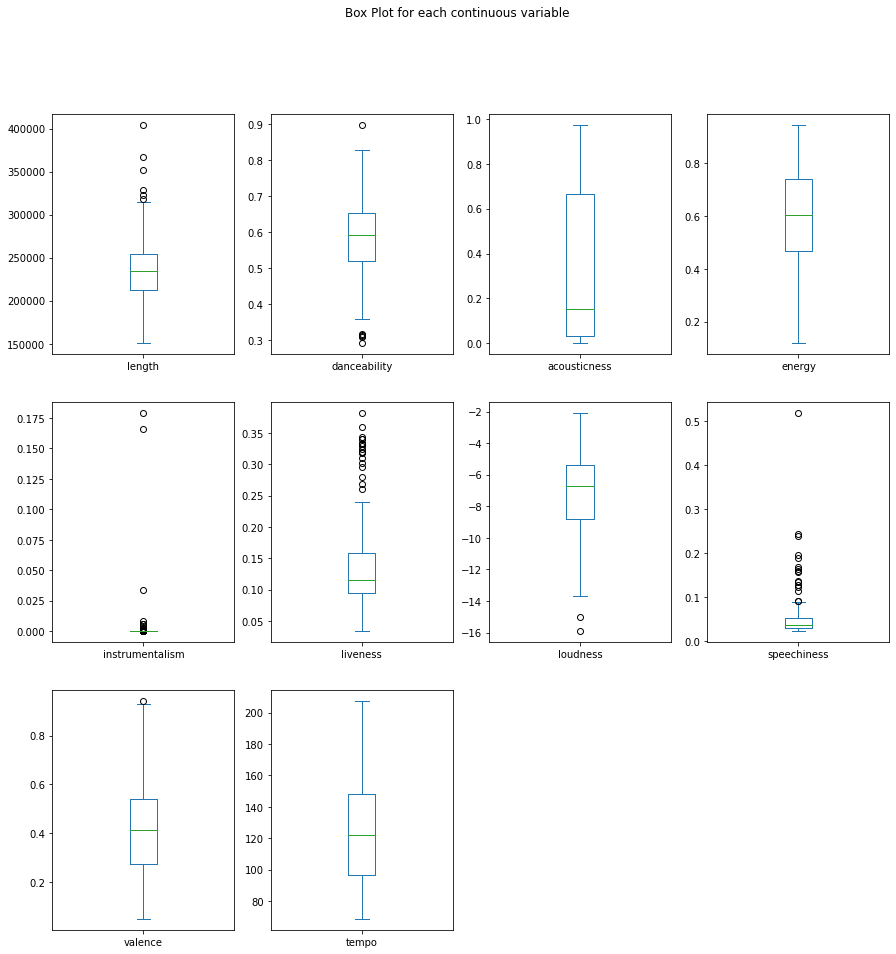

In [10]:
(df.drop(columns=['Mood'])
 .plot(kind='box', subplots=True, layout=(3, 4), figsize=(15, 15),
       title='Box Plot for each continuous variable'))
plt.show()

Box plot shows a few outliers on some features. We will use *StandardScaler* to scale our features.

In [11]:
df_scaled = df.copy()
df_scaled = df_scaled.drop(columns=['Mood'])
stdsc = StandardScaler()
scaled_features = stdsc.fit_transform(df_scaled.values)
df_scaled = pd.DataFrame(scaled_features, index=df_scaled.index,
                       columns=df_scaled.columns)
df_scaled = pd.merge(df_scaled, df['Mood'], left_index=True, right_index=True)
print(df_scaled.shape)
display(df_scaled.head())

(166, 11)


,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood
0,-0.157487,-0.062701,0.781020,-0.532559,-0.136528,-0.267716,0.286817,-0.543983,0.027747,-1.546523,Heartbreak--sad
1,-1.706187,0.617813,-0.434959,1.556084,-0.136528,-0.599744,1.960858,-0.407774,2.117534,-0.607179,Heartbreak--mad
2,-0.919928,0.295005,-0.087104,-0.932973,-0.136528,-0.294493,0.103071,-0.581819,-0.689958,-0.786079,Heartbreak--sad
3,-1.020656,-0.097599,-0.803987,1.014985,-0.136528,2.396541,1.660497,-0.405882,0.043579,-0.307308,Others
4,0.023693,-1.476075,-0.301866,-0.581258,-0.136528,-0.240940,0.552653,-0.515606,-0.837721,1.615080,It's complicated--loosing love


## Exploratory Data Analysis

### Target Variable Count

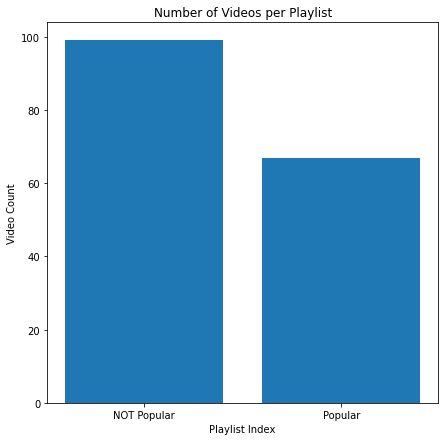

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(y.value_counts().index, y.value_counts().values)
ticks = [0, 1]
labels = ['NOT Popular', 'Popular']
# plt.xticks(ticks, labels)
ax.set_xticks(ticks, labels)
ax.set_xlabel('Playlist Index')
ax.set_ylabel('Video Count')
ax.set_title('Number of Videos per Playlist')
plt.show()

### Pairplot

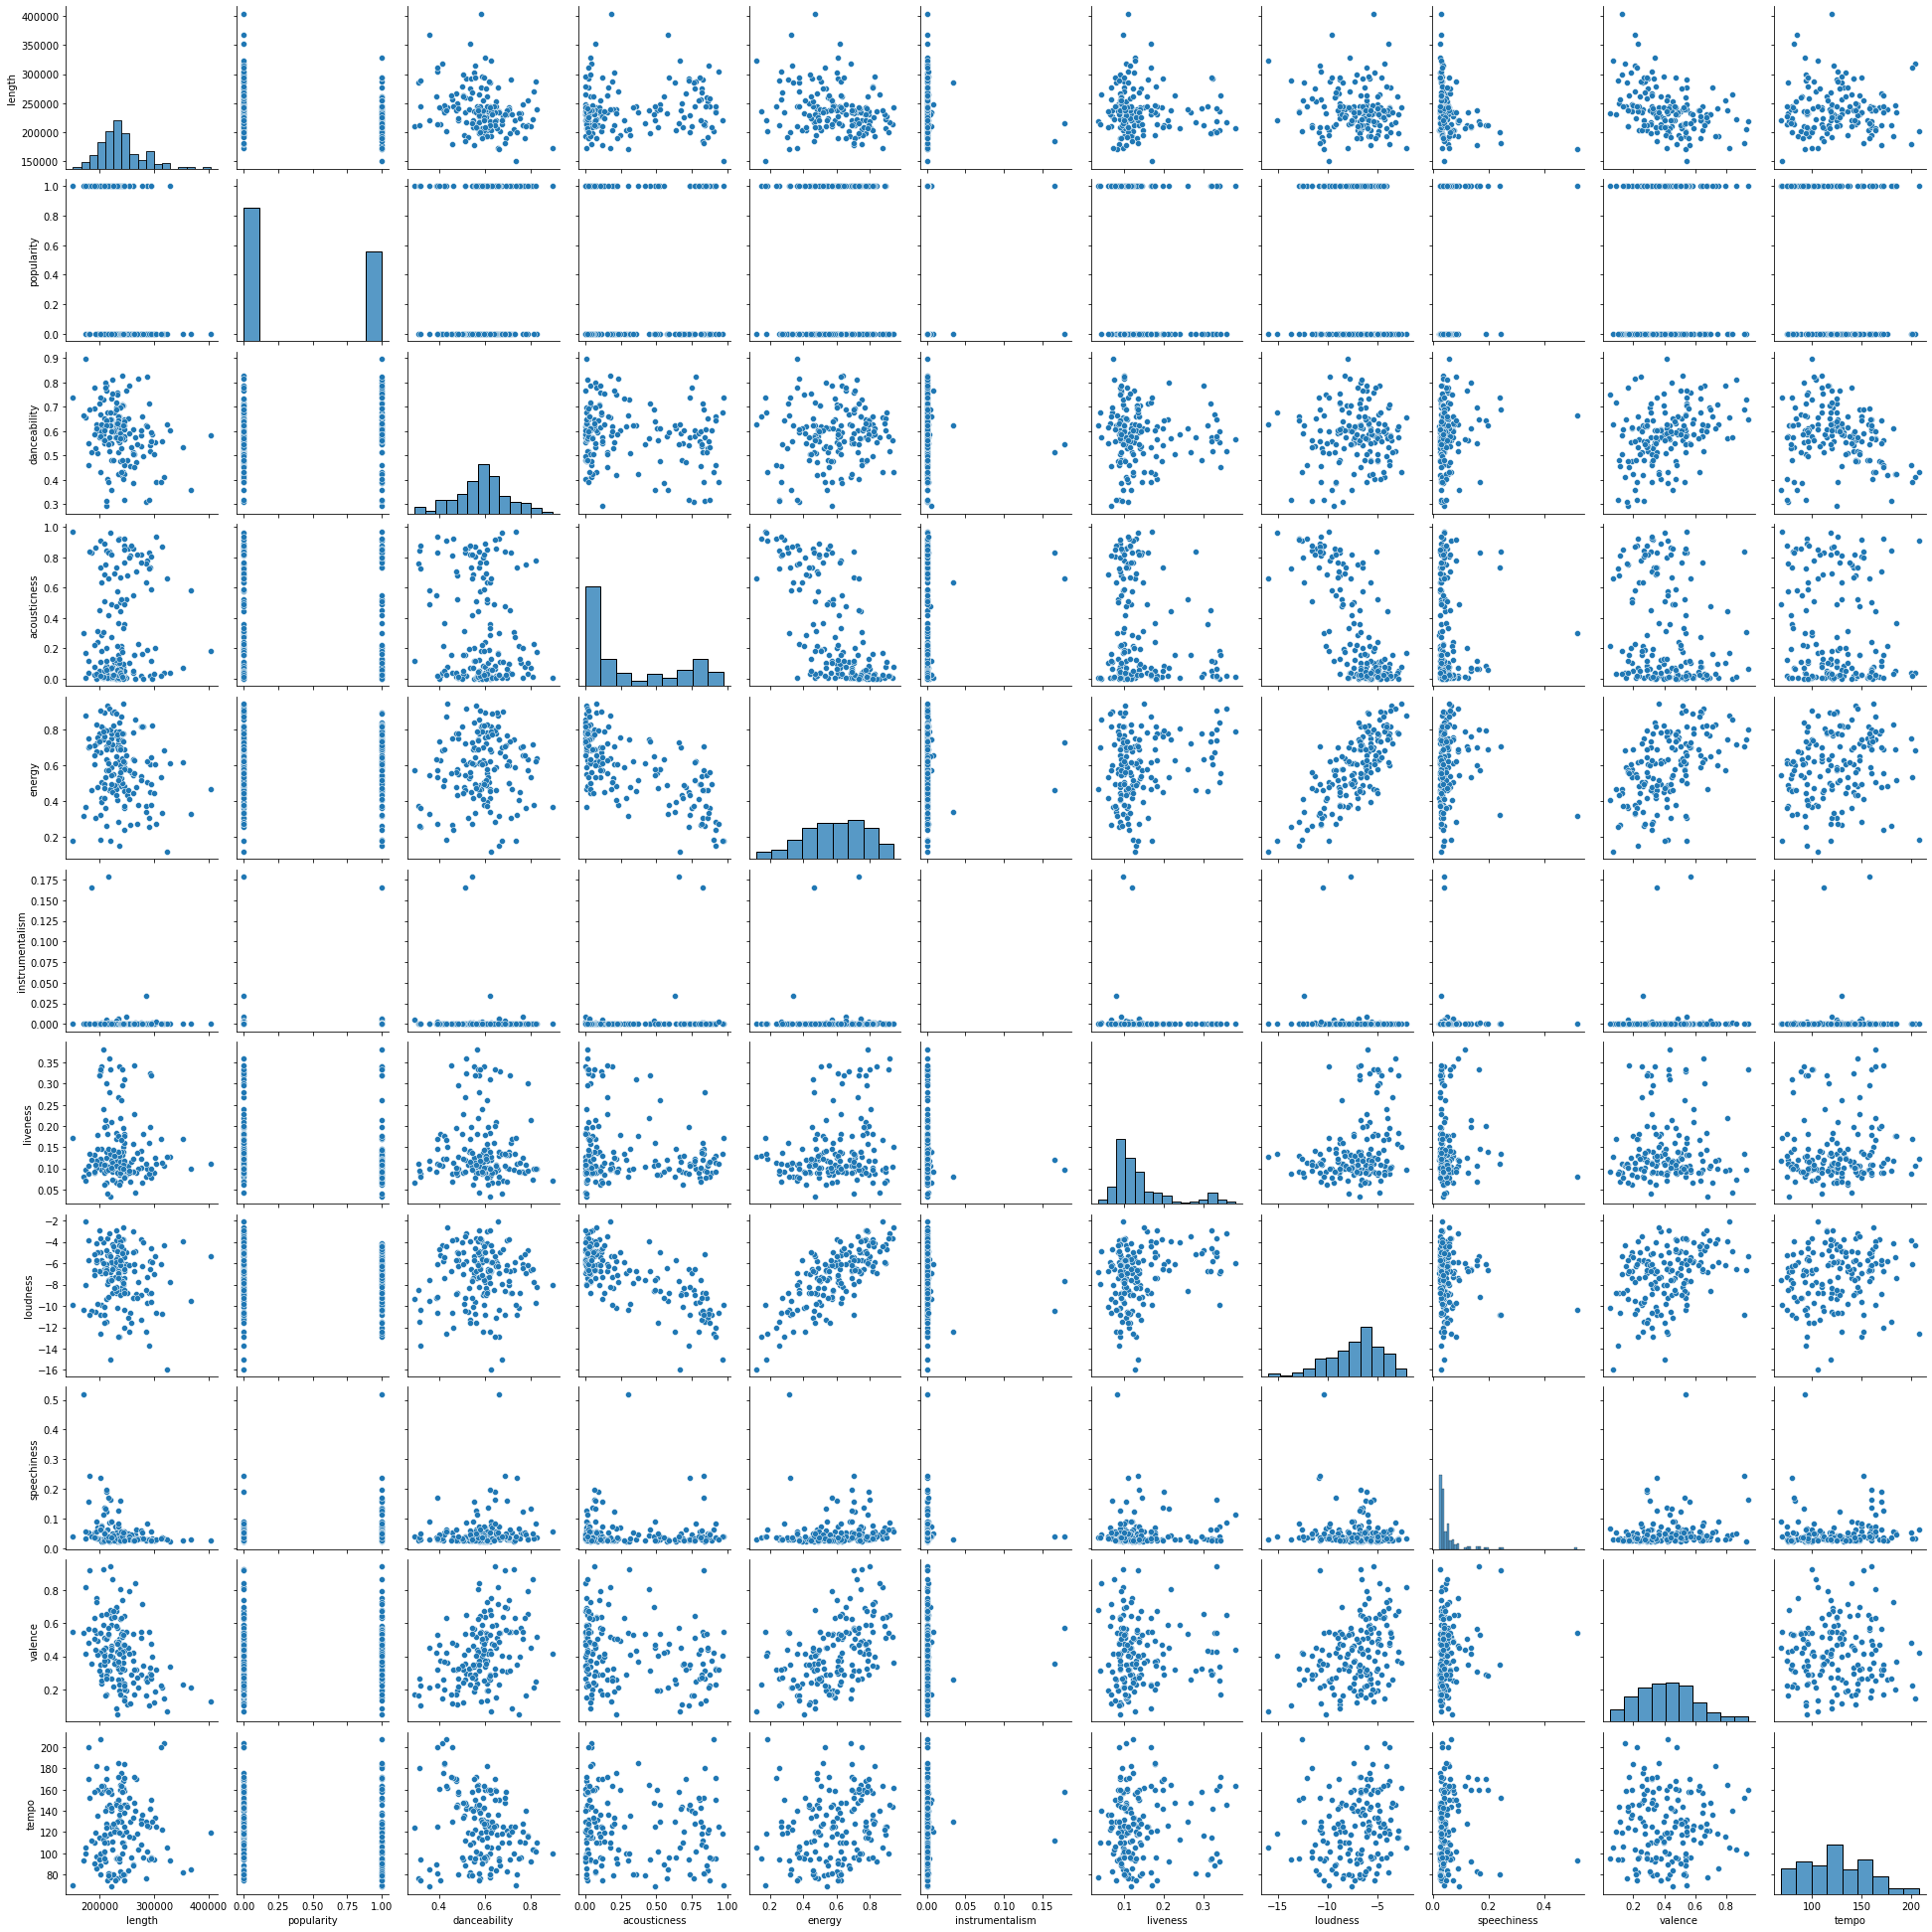

In [13]:
sns.pairplot(data)
plt.show()

### Heatmap

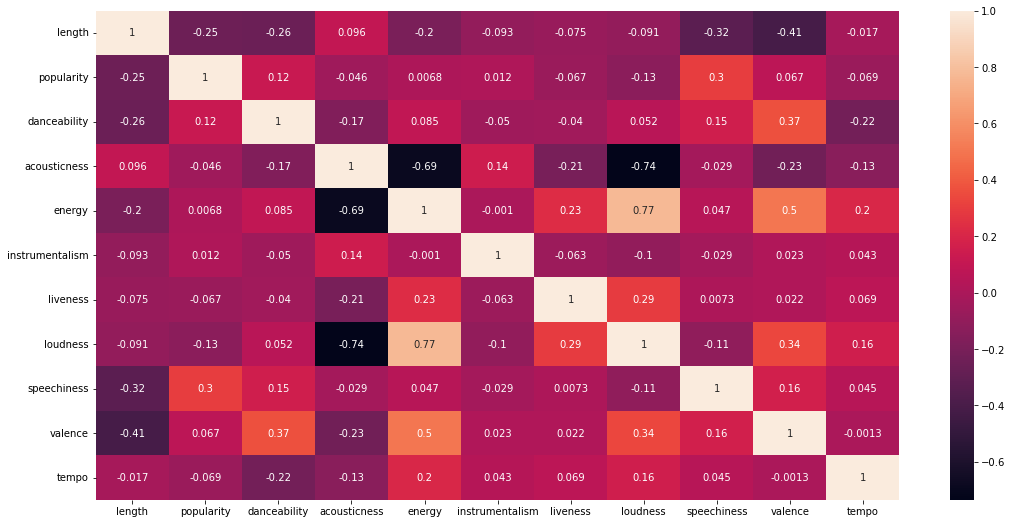

In [14]:
corr = data.corr()
plt.figure(figsize=(18, 9))
sns.heatmap(corr, annot=True)
plt.show()

**Insights:**
* `popularity` doesn't show any strong correlation with other features
* `energy` shows positive correlation (0.77) with `loudness`
* `acousticness` shows negative correlation (-0.69) with `energy`
* `acousticness` shows negative correlation (-0.74) with `loudness`
* This is expected given the nature of their behavoir describing an audio

### Correlation Plots

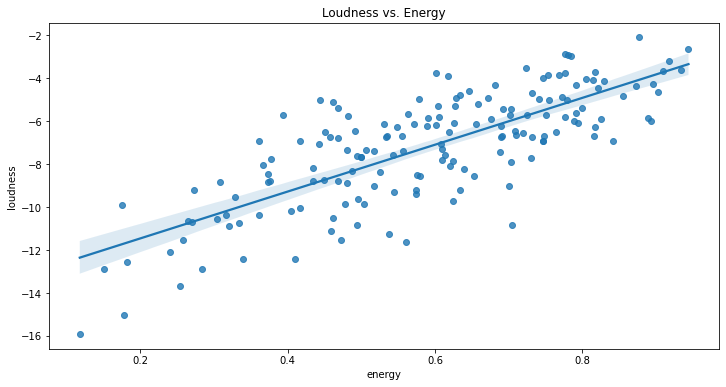

In [15]:
# Loudness vs. Energy (Positive Correlation)
plt.figure(figsize=(12, 6))
sns.regplot(x=df['energy'], y=df['loudness'])
plt.title('Loudness vs. Energy')
plt.show()

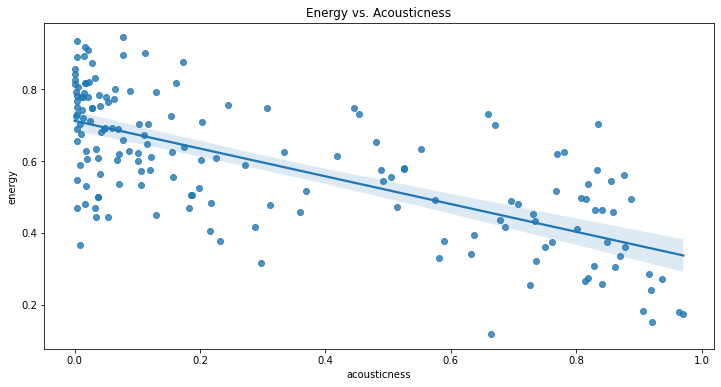

In [16]:
# Energy vs. Acousticness (Negative Correlation)
plt.figure(figsize=(12, 6))
sns.regplot(x=df['acousticness'], y=df['energy'])
plt.title('Energy vs. Acousticness')
plt.show()

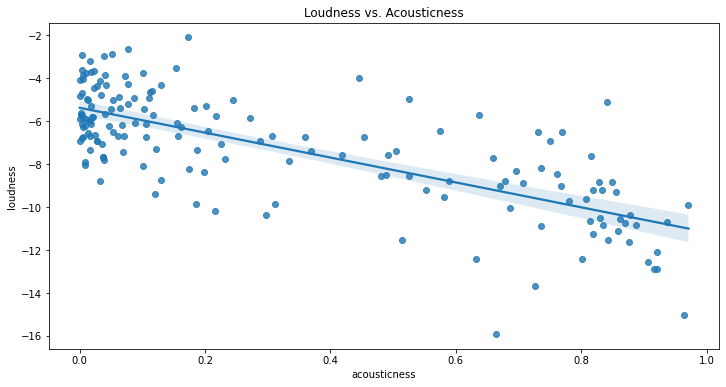

In [17]:
# Loudness vs. Acousticness (Negative Correlation)
plt.figure(figsize=(12, 6))
sns.regplot(x=df['acousticness'], y=df['loudness'])
plt.title('Loudness vs. Acousticness')
plt.show()

##  Handling Categorical Data (Class Learning)

For this section we will use XGBoost model so that all the model results will be comparable. At the end of this sub-section we are going to introduce the new experimental parameter (starting from version 1.6) of XGBoost model.

### Label Encoding

In [18]:
X_le = df.copy()
mood_map = {'Heartbreak--sad': 0,
            'Heartbreak--mad': 1,
            "It's complicated--loosing love": 2,
            "It's complicated--wanting love": 3,
            'Love--new love': 4,
            'Love--already fallen': 5,
            'Others': 6}
X_le['Mood'] = X_le['Mood'].map(mood_map)
display(X_le)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,0
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,1
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,0
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,6
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,2
...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,1
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,0
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,2
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,2


Optimal Parameters: {'eta': 0.01, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}
Top predictor: speechiness
Run Time = 2.90 s
Train Score = 74.09 %
Test Score = 72.46 %


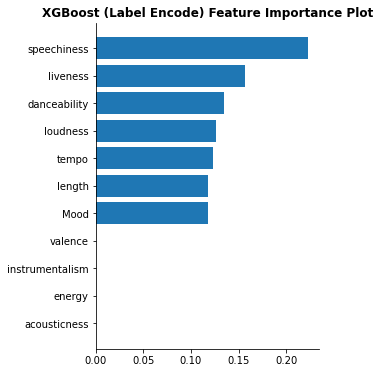

In [19]:
# GridSearchCV
model = xgb.XGBClassifier(tree_method="hist")
scoring = 'accuracy'
cv = 10
n_estimators = [100, 150, 200]
max_depth = [1, 3, 5, 7]
subsample = [0.5, 0.7, 0.9]
eta = [0.01, 0.1, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
              'subsample': subsample, 'eta': eta}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=cv, scoring=scoring, return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_le, y)

# Save all results into dataframe and get optimal test score
cv_results = grid_search.__dict__['cv_results_']
df_results = pd.DataFrame(
    {'Parameters': cv_results['params'],
     'Runtime': cv_results['mean_fit_time'],
     'Train Score': cv_results['mean_train_score'],
     'Test Score': cv_results['mean_test_score']})
best_i = np.argmax(df_results['Test Score'])

# Extract the best estimator and get its feature importances
best_estimator = grid_search.best_estimator_
feature_imp = best_estimator.feature_importances_
feature_names = grid_search.feature_names_in_
top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

# Print GridSearchCV optimal results
print(f"Optimal Parameters: {df_results.loc[best_i, 'Parameters']}")
print(f"Top predictor: {top_predictor}")
print(f"Run Time = {df_results.loc[best_i, 'Runtime']:.2f} s")
print(f"Train Score = {100*df_results.loc[best_i, 'Train Score']:.2f} %")
print(f"Test Score = {100*df_results.loc[best_i, 'Test Score']:.2f} %")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(4, 6))
sorted_index = np.argsort(abs(feature_imp))
ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
ax.set_title('XGBoost (Label Encode) Feature Importance Plot', weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### One Hot Encoding / Dummy Encoding

***One-hot encoder (OHE)*** is easy to implement, but its disadvantages lie when the categorical feature we want to encode has high cardinality. It means that it has many unique categories. Recall that for each unique category, the OHE will add columns. It could get out of hand when the data has several unique categories. For example, a feature with ten unique categories will yield ten new columns under OHE encoding, while nine new columns for dummy encoding (dropping 1 column).

In [20]:
X_ohe = df.copy()
X_ohe = pd.get_dummies(X_ohe, columns=['Mood'], drop_first=True)
display(X_ohe)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood_Heartbreak--sad,Mood_It's complicated--loosing love,Mood_It's complicated--wanting love,Mood_Love--already fallen,Mood_Love--new love,Mood_Others
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,1,0,0,0,0,0
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,0,0,0,0,0,0
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,1,0,0,0,0,0
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,0,0,0,0,0,1
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,0,0,0,0,0,0
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,1,0,0,0,0,0
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,0,1,0,0,0,0
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,0,1,0,0,0,0


Optimal Parameters: {'eta': 0.01, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}
Top predictor: speechiness
Run Time = 0.46 s
Train Score = 73.96 %
Test Score = 72.46 %


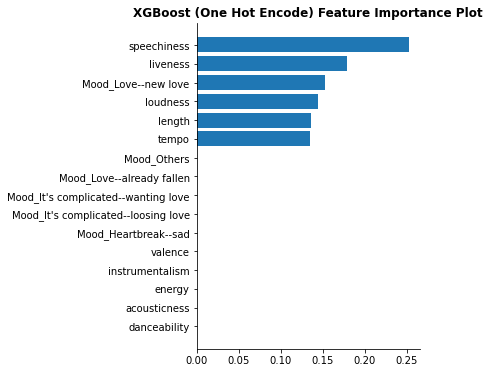

In [21]:
# GridSearchCV
model = xgb.XGBClassifier(tree_method="hist")
scoring = 'accuracy'
cv = 10
n_estimators = [100, 150, 200]
max_depth = [1, 3, 5, 7]
subsample = [0.3, 0.5, 0.7, 0.9]
eta = [0.01, 0.1, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
              'subsample': subsample, 'eta': eta}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=cv, scoring=scoring, return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_ohe, y)

# Save all results into dataframe and get optimal test score
cv_results = grid_search.__dict__['cv_results_']
df_results = pd.DataFrame(
    {'Parameters': cv_results['params'],
     'Runtime': cv_results['mean_fit_time'],
     'Train Score': cv_results['mean_train_score'],
     'Test Score': cv_results['mean_test_score']})
best_i = np.argmax(df_results['Test Score'])

# Extract the best estimator and get its feature importances
best_estimator = grid_search.best_estimator_
feature_imp = best_estimator.feature_importances_
feature_names = grid_search.feature_names_in_
top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

# Print GridSearchCV optimal results
print(f"Optimal Parameters: {df_results.loc[best_i, 'Parameters']}")
print(f"Top predictor: {top_predictor}")
print(f"Run Time = {df_results.loc[best_i, 'Runtime']:.2f} s")
print(f"Train Score = {100*df_results.loc[best_i, 'Train Score']:.2f} %")
print(f"Test Score = {100*df_results.loc[best_i, 'Test Score']:.2f} %")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(4, 6))
sorted_index = np.argsort(abs(feature_imp))
ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
ax.set_title('XGBoost (One Hot Encode) Feature Importance Plot', weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Binary Encoding

***Binary Encoding (BE)*** solves the issue of multiple cardinalities of OHE by using all unique combinations of 0 and 1 to represent the unique category. For example, in OHE, the dummy columns can only have one value of 1 per row, but for binary encoding, it can have multiple values of one. What matters in binary encoding is the combination of those zeros and ones. By doing this, BE reduces the number of columns necessary to represent each unique category in our feature column. One drawback in using BE is that we lose our capability to give feature importance value for each unique category since it is encoded using a combination of columns.

In [22]:
X_be = df.copy()
be = ce.BinaryEncoder(cols=['Mood'], return_df=True) 
data_be = be.fit_transform(X_be['Mood']) 
X_be = pd.concat([X_be, data_be], axis=1).drop(columns=['Mood'])
display(X_be)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood_0,Mood_1,Mood_2
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,0,0,1
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,0,1,0
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,0,0,1
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,0,1,1
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,0,1,0
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,0,0,1
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,1,0,0
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,1,0,0


Optimal Parameters: {'eta': 0.01, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}
Top predictor: speechiness
Run Time = 0.15 s
Train Score = 74.29 %
Test Score = 72.46 %


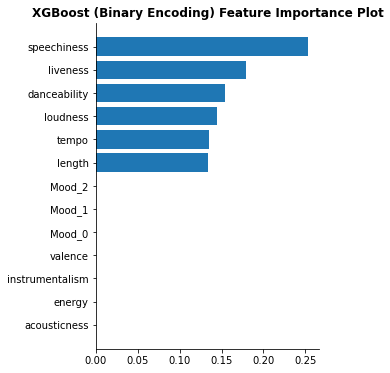

In [23]:
# GridSearchCV
model = xgb.XGBClassifier(tree_method="hist")
scoring = 'accuracy'
cv = 10
n_estimators = [100, 150, 200]
max_depth = [1, 3, 5, 7]
subsample = [0.3, 0.5, 0.7, 0.9]
eta = [0.01, 0.1, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
              'subsample': subsample, 'eta': eta}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=cv, scoring=scoring, return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_be, y)

# Save all results into dataframe and get optimal test score
cv_results = grid_search.__dict__['cv_results_']
df_results = pd.DataFrame(
    {'Parameters': cv_results['params'],
     'Runtime': cv_results['mean_fit_time'],
     'Train Score': cv_results['mean_train_score'],
     'Test Score': cv_results['mean_test_score']})
best_i = np.argmax(df_results['Test Score'])

# Extract the best estimator and get its feature importances
best_estimator = grid_search.best_estimator_
feature_imp = best_estimator.feature_importances_
feature_names = grid_search.feature_names_in_
top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

# Print GridSearchCV optimal results
print(f"Optimal Parameters: {df_results.loc[best_i, 'Parameters']}")
print(f"Top predictor: {top_predictor}")
print(f"Run Time = {df_results.loc[best_i, 'Runtime']:.2f} s")
print(f"Train Score = {100*df_results.loc[best_i, 'Train Score']:.2f} %")
print(f"Test Score = {100*df_results.loc[best_i, 'Test Score']:.2f} %")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(4, 6))
sorted_index = np.argsort(abs(feature_imp))
ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
ax.set_title('XGBoost (Binary Encoding) Feature Importance Plot', weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Base N Encoding (Base=3)

***Base N Encoding (BNE)*** extends the idea we introduce in binary encoding to solve the high cardinality of some categorical features. Instead of just using 0 and 1, we can now use other digits depending on the base we set. For example, for a base equal to three, each unique combination of digits 0, 1, and 2 represents a unique category. Its consequence is that we could further reduce the columns we need to encode our categorical feature. However, like Binary Encoding, BNE lacks clear and traceable columns for the unique category. As a result, we could no longer pinpoint if a specific category was a top predictor in our model.

In [24]:
X_bn = df.copy()
bn = ce.BinaryEncoder(cols=['Mood'], return_df=True, base=3) 
data_bn = bn.fit_transform(X_bn['Mood']) 
X_bn = pd.concat([X_bn, data_bn], axis=1).drop(columns=['Mood'])
display(X_bn)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood_0,Mood_1
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,0,1
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,0,2
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,0,1
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,1,0
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,0,2
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,0,1
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,1,1
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,1,1


Optimal Parameters: {'eta': 0.01, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}
Top predictor: speechiness
Run Time = 0.20 s
Train Score = 74.03 %
Test Score = 72.46 %


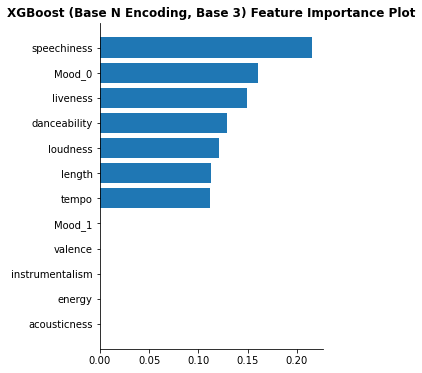

In [25]:
# GridSearchCV
model = xgb.XGBClassifier(tree_method="hist")
scoring = 'accuracy'
cv = 10
n_estimators = [100, 150, 200]
max_depth = [1, 3, 5, 7]
subsample = [0.3, 0.5, 0.7, 0.9]
eta = [0.01, 0.1, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
              'subsample': subsample, 'eta': eta}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=cv, scoring=scoring, return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_bn, y)

# Save all results into dataframe and get optimal test score
cv_results = grid_search.__dict__['cv_results_']
df_results = pd.DataFrame(
    {'Parameters': cv_results['params'],
     'Runtime': cv_results['mean_fit_time'],
     'Train Score': cv_results['mean_train_score'],
     'Test Score': cv_results['mean_test_score']})
best_i = np.argmax(df_results['Test Score'])

# Extract the best estimator and get its feature importances
best_estimator = grid_search.best_estimator_
feature_imp = best_estimator.feature_importances_
feature_names = grid_search.feature_names_in_
top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

# Print GridSearchCV optimal results
print(f"Optimal Parameters: {df_results.loc[best_i, 'Parameters']}")
print(f"Top predictor: {top_predictor}")
print(f"Run Time = {df_results.loc[best_i, 'Runtime']:.2f} s")
print(f"Train Score = {100*df_results.loc[best_i, 'Train Score']:.2f} %")
print(f"Test Score = {100*df_results.loc[best_i, 'Test Score']:.2f} %")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(4, 6))
sorted_index = np.argsort(abs(feature_imp))
ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
ax.set_title('XGBoost (Base N Encoding, Base 3) Feature Importance Plot', weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

We showcase here how we can use two other types of categorical encoders that solve the problem of one-hot encoding when it encounters a categorical feature with high cardinality. Other types of categorical encoding are highlighted in the list of categorical encoders below: [[4]](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/)
* Label Encoding
* One Hot Encoding
* Dummy Encoding
* Binary Encoding
* Base N Encoding
* ***Effect Encoding***
* ***Hash Encoding***
* ***Target Encoding***

### XGB (enable_categorical)

Introduce in version 1.6 XGBoost model now has a new parameter called `enable_categorical`. It has two possible values: `True` and `False`(default). When this parameter was set to true, all categorical feature in the model's input can be processed even in text form. No need to perform categorical encoding, but the model is required to set the data type of the categorical feature column into `category`. `enable_categorical` is an experimental parameter only; therefore, it has limited features. This parameter can only be used on XGBoost `tree_method's`: `approx`, `hist`, and `gpu_hist`. The default `tree_method`=`exact` does not yet support this parameter. [[5]](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html)

In [26]:
X_cat = df.copy()
X_cat['Mood'] = X_cat['Mood'].astype('category')
display(X_cat)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,Heartbreak--sad
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,Heartbreak--mad
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,Heartbreak--sad
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,Others
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,It's complicated--loosing love
...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,Heartbreak--mad
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,Heartbreak--sad
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,It's complicated--loosing love
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,It's complicated--loosing love


Optimal Parameters: {'eta': 0.01, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}
Top predictor: speechiness
Run Time = 1.10 s
Train Score = 74.29 %
Test Score = 72.46 %


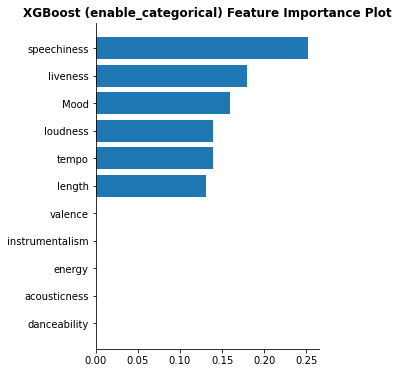

In [27]:
# GridSearchCV
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
scoring = 'accuracy'
cv = 10
n_estimators = [100, 150, 200]
max_depth = [1, 3, 5, 7]
subsample = [0.3, 0.5, 0.7, 0.9]
eta = [0.01, 0.1, 1]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
              'subsample': subsample, 'eta': eta}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=cv, scoring=scoring, return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_cat, y)

# Save all results into dataframe and get optimal test score
cv_results = grid_search.__dict__['cv_results_']
df_results = pd.DataFrame(
    {'Parameters': cv_results['params'],
     'Runtime': cv_results['mean_fit_time'],
     'Train Score': cv_results['mean_train_score'],
     'Test Score': cv_results['mean_test_score']})
best_i = np.argmax(df_results['Test Score'])

# Extract the best estimator and get its feature importances
best_estimator = grid_search.best_estimator_
feature_imp = best_estimator.feature_importances_
feature_names = grid_search.feature_names_in_
top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

# Print GridSearchCV optimal results
print(f"Optimal Parameters: {df_results.loc[best_i, 'Parameters']}")
print(f"Top predictor: {top_predictor}")
print(f"Run Time = {df_results.loc[best_i, 'Runtime']:.2f} s")
print(f"Train Score = {100*df_results.loc[best_i, 'Train Score']:.2f} %")
print(f"Test Score = {100*df_results.loc[best_i, 'Test Score']:.2f} %")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(4, 6))
sorted_index = np.argsort(abs(feature_imp))
ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
ax.set_title('XGBoost (enable_categorical) Feature Importance Plot', weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Auto ML Functions

For this section we will use the `df` as features for our tree based models and `df_scaled` for our non-tree based models. On the other hand, our categorical feature will be one-hot encoded.

In [28]:
# Non-scaled features
X = df.copy()
X = pd.get_dummies(X, columns=['Mood'], drop_first=True)
display(X)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood_Heartbreak--sad,Mood_It's complicated--loosing love,Mood_It's complicated--wanting love,Mood_Love--already fallen,Mood_Love--new love,Mood_Others
0,232106,0.580,0.575,0.491,0.000000,0.1210,-6.462,0.0251,0.425,76.009,1,0,0,0,0,0
1,173066,0.658,0.173,0.877,0.000000,0.0962,-2.098,0.0323,0.821,105.586,0,0,0,0,0,0
2,203040,0.621,0.288,0.417,0.000000,0.1190,-6.941,0.0231,0.289,99.953,1,0,0,0,0,0
3,199200,0.576,0.051,0.777,0.000000,0.3200,-2.881,0.0324,0.428,115.028,0,0,0,0,0,1
4,239013,0.418,0.217,0.482,0.000000,0.1230,-5.769,0.0266,0.261,175.558,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,277591,0.660,0.162,0.817,0.000000,0.0667,-6.269,0.0521,0.714,135.942,0,0,0,0,0,0
162,244236,0.609,0.849,0.373,0.000000,0.0779,-8.819,0.0263,0.130,106.007,1,0,0,0,0,0
163,189495,0.588,0.225,0.608,0.000000,0.0920,-7.062,0.0365,0.508,90.201,0,1,0,0,0,0
164,208608,0.563,0.514,0.473,0.000012,0.1090,-11.548,0.0503,0.405,101.934,0,1,0,0,0,0


In [29]:
# Scaled features
X_scaled = df_scaled.copy()
X_scaled = pd.get_dummies(X_scaled, columns=['Mood'], drop_first=True)
display(X_scaled)

,length,danceability,acousticness,energy,instrumentalism,liveness,loudness,speechiness,valence,tempo,Mood_Heartbreak--sad,Mood_It's complicated--loosing love,Mood_It's complicated--wanting love,Mood_Love--already fallen,Mood_Love--new love,Mood_Others
0,-0.157487,-0.062701,0.781020,-0.532559,-0.136528,-0.267716,0.286817,-0.543983,0.027747,-1.546523,1,0,0,0,0,0
1,-1.706187,0.617813,-0.434959,1.556084,-0.136528,-0.599744,1.960858,-0.407774,2.117534,-0.607179,0,0,0,0,0,0
2,-0.919928,0.295005,-0.087104,-0.932973,-0.136528,-0.294493,0.103071,-0.581819,-0.689958,-0.786079,1,0,0,0,0,0
3,-1.020656,-0.097599,-0.803987,1.014985,-0.136528,2.396541,1.660497,-0.405882,0.043579,-0.307308,0,0,0,0,0,1
4,0.023693,-1.476075,-0.301866,-0.581258,-0.136528,-0.240940,0.552653,-0.515606,-0.837721,1.615080,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,1.035647,0.635262,-0.468232,1.231425,-0.136528,-0.994697,0.360852,-0.033198,1.552869,0.356905,0,0,0,0,0,0
162,0.160699,0.190310,1.609821,-1.171056,-0.136528,-0.844749,-0.617334,-0.521281,-1.529039,-0.593808,1,0,0,0,0,0
163,-1.275232,0.007095,-0.277668,0.100527,-0.136528,-0.655975,0.056655,-0.328318,0.465758,-1.095795,0,1,0,0,0,0
164,-0.773872,-0.211018,0.596506,-0.629957,-0.135896,-0.428375,-1.664185,-0.067250,-0.077798,-0.723164,0,1,0,0,0,0


### KNN

In [30]:
def knn(X, y):
    # GridSearchCV
    model = KNeighborsClassifier()
    scoring = 'accuracy'
    cv = 10
    n_neighbors = np.arange(1,30,2)
    param_grid = {'n_neighbors': n_neighbors}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # KNN has no Feature Importance Plot

    return ['KNN',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            'NA',
            df_results.loc[best_i, 'Runtime']]

### Logistic Regression (Lasso)

In [31]:
def lr1(X, y):
    # GridSearchCV
    model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100_000)
    scoring = 'accuracy'
    cv = 10
    C = [1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 100, 1000]
    param_grid = {'C': C}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.coef_.ravel()
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('Logistic Regression (Lasso) Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    return ['Logistic Regression (Lasso)',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### Logistic Regression (Ridge)

In [32]:
def lr2(X, y):
    # GridSearchCV
    model = LogisticRegression(penalty='l2', dual=False, max_iter=100_000)
    scoring = 'accuracy'
    cv = 10
    C = [1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 100, 1000]
    param_grid = {'C': C}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.coef_.ravel()
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('Logistic Regression (Ridge) Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    return ['Logistic Regression (Ridge)',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### SVM (Lasso)

In [33]:
def svm1(X, y):
    # GridSearchCV
    model = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=100_000)
    scoring = 'accuracy'
    cv = 10
    C = [1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 100, 1000]
    param_grid = {'C': C}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.coef_.ravel()
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('SVM (Lasso) Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    return ['SVM (Lasso)',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### SVM (Ridge)

In [34]:
def svm2(X, y):
    # GridSearchCV
    model = LinearSVC(penalty='l2', max_iter=1_000_000)
    scoring = 'accuracy'
    cv = 10
    C = [1e-2, 0.1, 0.5, 1, 5, 10, 100]
    param_grid = {'C': C}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.coef_.ravel()
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('SVM (Ridge) Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    return ['SVM (Ridge)',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### Decision Tree

In [35]:
def dt(X, y):
    # GridSearchCV
    model = DecisionTreeClassifier()
    scoring = 'accuracy'
    cv = 10
    max_depth = [3, 5, 7, 10, 15, 20, 25, 30, 40, 50]
    param_grid = {'max_depth': max_depth}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('Decision Tree Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    return ['Decision Tree',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### Random Forest

In [36]:
def rf(X, y):    
    # GridSearchCV
    model = RandomForestClassifier()
    scoring = 'accuracy'
    cv = 10
    n_estimators = [100, 150, 200, 250]
    max_depth = [3, 5, 10, 20, 30, 50]
    param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                               scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('Random Forest Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    return ['Random Forest',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### GBM

In [37]:
def gbm(X, y):
    # GridSearchCV
    model = GradientBoostingClassifier()
    scoring = 'accuracy'
    cv = 10
    n_estimators = [100, 150, 200]
    max_depth = [1, 3, 5, 7]
    max_features = [0.3, 0.5, 0.7, 0.9]
    learning_rate = [0.01, 0.1, 1]
    param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
                  'max_features': max_features, 'learning_rate': learning_rate}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('GBM Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    return ['GBM',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### XGBoost

In [38]:
def xg(X, y):
    # GridSearchCV
    model = xgb.XGBClassifier(tree_method="hist")
    scoring = 'accuracy'
    cv = 10
    n_estimators = [100, 150, 200]
    max_depth = [1, 3, 5, 7]
    subsample = [0.3, 0.5, 0.7, 0.9]
    eta = [0.01, 0.1, 1]
    param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
                  'subsample': subsample, 'eta': eta}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('XGBoost Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    return ['XGBoost',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### AdaBoost

In [39]:
def ada(X, y):
    # GridSearchCV
    model = AdaBoostClassifier()
    scoring = 'accuracy'
    cv = 10
    n_estimators = [100, 150, 200]
    learning_rate = [0.01, 0.1, 1]
    param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = grid_search.feature_names_in_
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('AdaBoost Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    return ['AdaBoost',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

### Light GBM

In [40]:
def lgbm(X, y):
    # GridSearchCV
    model = ltb.LGBMClassifier()
    scoring = 'accuracy'
    cv = 10
    n_estimators = [100, 150, 200]
    max_depth = [1, 3, 5, 7]
    subsample = [0.3, 0.5, 0.7, 0.9]
    learning_rate = [0.01, 0.1, 1]
    param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,
                  'subsample': subsample, 'learning_rate': learning_rate}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=cv, scoring=scoring, return_train_score=True,
                               n_jobs=-1)
    grid_search.fit(X, y)

    # Save all results into dataframe and get optimal test score
    cv_results = grid_search.__dict__['cv_results_']
    df_results = pd.DataFrame(
        {'Parameters': cv_results['params'],
         'Runtime': cv_results['mean_fit_time'],
         'Train Score': cv_results['mean_train_score'],
         'Test Score': cv_results['mean_test_score']})
    best_i = np.argmax(df_results['Test Score'])

    # Extract the best estimator and get its feature importances
    best_estimator = grid_search.best_estimator_
    feature_imp = best_estimator.feature_importances_
    feature_names = X.columns
    top_predictor = feature_names[np.argmax(np.abs(feature_imp))]

    # Feature Importance Plot
    fig, ax = plt.subplots(figsize=(4, 6))
    sorted_index = np.argsort(abs(feature_imp))
    ax.barh(feature_names[sorted_index], abs(feature_imp)[sorted_index])
    ax.set_title('Light GBM Feature Importance Plot', weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    return ['Light GBM',
            df_results.loc[best_i, 'Train Score'],
            df_results.loc[best_i, 'Test Score'],
            df_results.loc[best_i, 'Parameters'],
            top_predictor,
            df_results.loc[best_i, 'Runtime']]

## Auto-ML Summary of Results

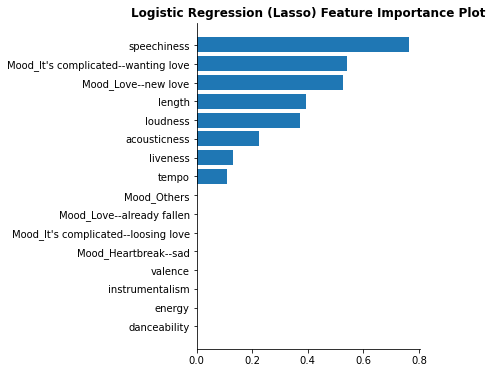

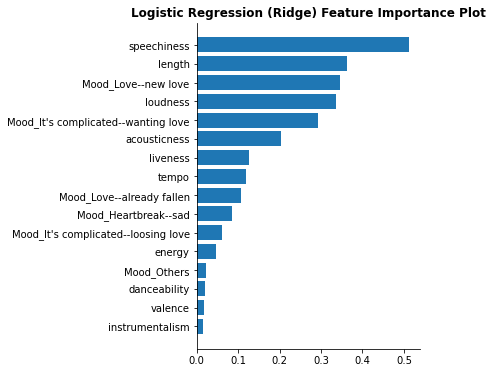

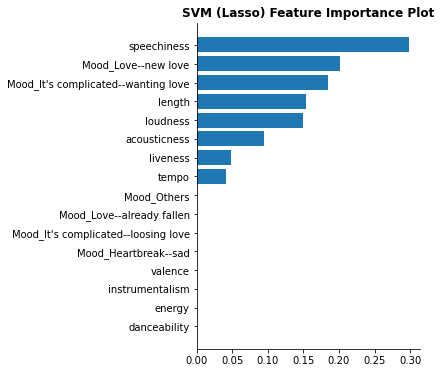

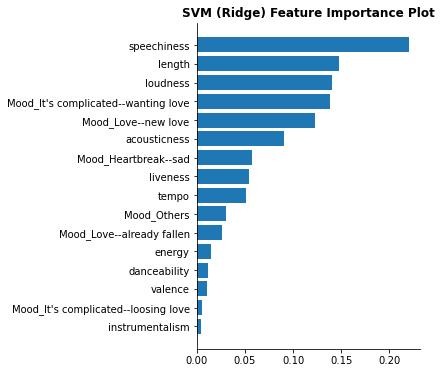

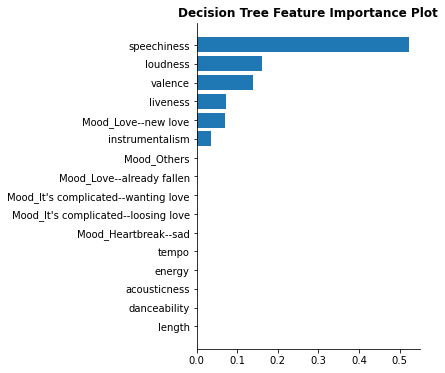

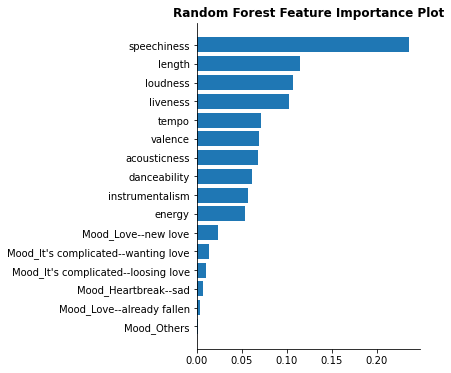

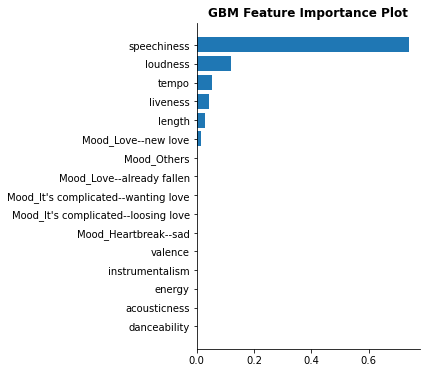

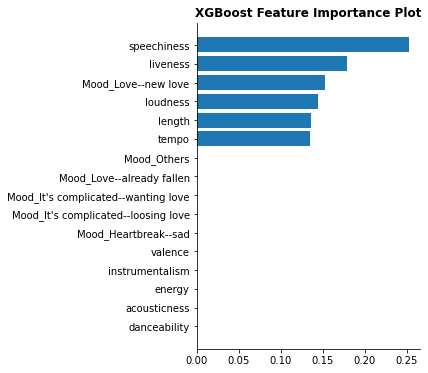

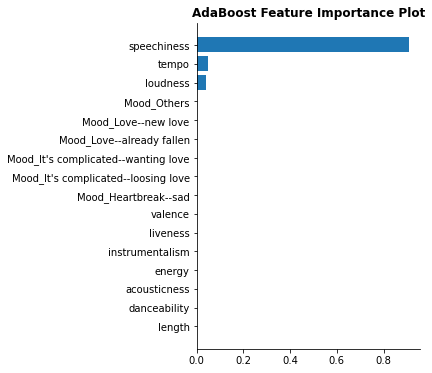

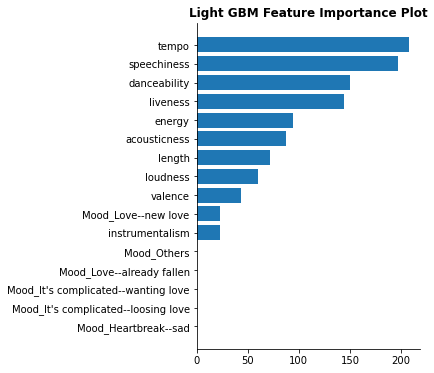

In [41]:
# KNN
a = knn(X_scaled, y)

# Logistic Regression (w/ Lasso)
b = lr1(X_scaled, y)

# Logistic Regression (w/ Ridge)
c = lr2(X_scaled, y)

# SVM (w/ Lasso)
d = svm1(X_scaled, y)

# SVM (w/ Ridge)
e = svm2(X_scaled, y)

# Decision Tree
f = dt(X, y)

# Random Forest
g = rf(X, y)

# Gradient Boosting Method
h = gbm(X, y)

# XGBoost
i = xg(X, y)

# AdaBoost
j = ada(X, y)

# Light GBM
k = lgbm(X, y)

In [42]:
# Summary Table
pd.set_option('display.max_colwidth', None)
cols = ['ML Method', 'Train Accuracy', 'Test Accuracy', 'Optimal Parameter',
        'Top Predictor', 'Run Time']
df_summary = pd.DataFrame(columns=cols)
df_summary.loc[0] = a
df_summary.loc[1] = b
df_summary.loc[2] = c
df_summary.loc[3] = d
df_summary.loc[4] = e
df_summary.loc[5] = f
df_summary.loc[6] = g
df_summary.loc[7] = h
df_summary.loc[8] = i
df_summary.loc[9] = j
df_summary.loc[10] = k
display(df_summary)

,ML Method,Train Accuracy,Test Accuracy,Optimal Parameter,Top Predictor,Run Time
0,KNN,0.682022,0.619853,{'n_neighbors': 9},NA,0.003989
1,Logistic Regression (Lasso),0.743606,0.647059,{'C': 0.5},speechiness,0.004813
2,Logistic Regression (Ridge),0.731579,0.654412,{'C': 0.1},speechiness,0.034381
3,SVM (Lasso),0.735593,0.647794,{'C': 0.1},speechiness,0.004177
4,SVM (Ridge),0.738268,0.648529,{'C': 0.01},speechiness,0.004868
5,Decision Tree,0.794470,0.617647,{'max_depth': 3},speechiness,0.011649
6,Random Forest,0.964506,0.695956,"{'max_depth': 5, 'n_estimators': 100}",speechiness,6.260682
7,GBM,0.778412,0.712132,"{'learning_rate': 0.01, 'max_depth': 1, 'max_features': 0.7, 'n_estimators': 200}",speechiness,3.781034
8,XGBoost,0.739579,0.724632,"{'eta': 0.01, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}",speechiness,0.190899
9,AdaBoost,0.773043,0.736397,"{'learning_rate': 0.01, 'n_estimators': 100}",speechiness,5.447744


# Conclusion

When dealing with a categorical feature, we can use different kinds of techniques for us to process text into numbers. Different encoding has its own advantages and disadvantage. When dealing with low cardinality nominal categorical features, we recommend One-Hot Encoding or Dummy Encoding, and for ordinal features, use Label Encoding. For features with high cardinality (many unique categories), it is recommended to use Binary Encoding or Base N Encoding to reduce the number of additional columns created (compared to one-hot encoding). But in doing so, we will lose our ability to track each category's feature importance. Also, XGBoost has a new way of handling categorical features using its parameter `enable_categorical`. All of these categorical handling methods shall be implemented depending on the data we are dealing with and the information we want from it.

Running the 11 machine learning models, we came up with a summary table of their performance using the same data. Most of the models perform well, beating the 1.25PCC but what stood out are `GBM`, `XGBoost`, and `AdaBoost`, which yield accuracy above 70%. Speechiness is the top predictor for almost all models. It is the amount of spoken words in the song. Taylor Swift is well known for her storytelling in her songs, so it is not surprising that this would be the top predictor. Using the model, we can now predict whether a song would be popular even before releasing it to the public. First, we must examine its audio characteristics and `Mood` category. From there, the song producer or Taylor Swift may adjust some aspects to make their model predicted unpopular songs into popular ones.

This machine learning method can be further improved by adding the elements of Natural Language Processing (NLP) to determine what words make a song popular. Taylor Swift is a great storyteller; her words have information we only need to discover further.

# References

[1] ticketmaster (2022, November 4) *Taylor Swift Announces 2023 U.S. Tour Dates*. Retrived November 18, 2022, from https://blog.ticketmaster.com/taylor-swift-the-eras-tour-2023/ <br><br>
[2] Dagohoy, J.L. (2021, November 6) *Taylor Swift Spotify Data*. Retrived November 18, 2022, from https://www.kaggle.com/datasets/thespacefreak/taylor-swift-spotify-data <br><br>
[3] Mage (2022, April 14) *Using machine learning (ML) to generate the ultimate Taylor Swift playlist*. Retrieved November 18, 2022, from https://dev.to/mage_ai/using-machine-learning-ml-to-generate-the-ultimate-taylor-swift-playlist-50e8 <br><br>
[4] Saxena, S. (2020, August 13) *Here’s All you Need to Know About Encoding Categorical Data (with Python code)*. Retrieved November 18, 2022, from https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/ <br><br>
[5] XGBoost (n.d.) *Categorical Data*. Retrieved November 18, 2022, from https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html